### Train a VLM in Google Colab!

### Clone the repository if you don't have it already

In [1]:
import os

if not os.path.isdir('nanoVLM'):
    !git clone https://github.com/huggingface/nanoVLM.git
%cd nanoVLM/
!ls

Cloning into 'nanoVLM'...
remote: Enumerating objects: 613, done.
remote: Counting objects: 100% (369/369), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 613 (delta 302), reused 240 (delta 231), pack-reused 244 (from 2)
Receiving objects: 100% (613/613), 13.25 MiB | 13.26 MiB/s, done.
Resolving deltas: 100% (385/385), done.
/content/nanoVLM
assets			data		 models		train.py
benchmark-inference.py	generate.py	 nanoVLM.ipynb
benchmark_suite.py	measure_vram.py  README.md


### Imports and Setup

In [2]:
# If you get an "Error" from pip's dependency resolver but the cell complets fine, this is not an issue, you can continue :)
!pip -q install torch
!pip -q install gcsfs
!pip -q install datasets==3.5.0
!pip -q install tqdm
!pip -q install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not

In [3]:
# nanoVLM Imports (please check out the implementations in detail, that's where all the interessting stuff is!)
from data.collators import VQACollator, MMStarCollator
from data.datasets import MMStarDataset, VQADataset
from data.processors import get_image_processor, get_tokenizer
from models.vision_language_model import VisionLanguageModel
import models.utils as utils

# Libraries
import math
import time
import torch
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from dataclasses import dataclass
from torch.utils.data import DataLoader
from datasets import load_dataset, concatenate_datasets

#Otherwise, the tokenizer will through a warning
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

# To reload the modules if you change something in the code
%reload_ext autoreload
%autoreload 2

Using device: cpu


### Get the dataloaders

In [4]:
def get_dataloaders(train_cfg, vlm_cfg):
    # Create datasets
    image_processor = get_image_processor(vlm_cfg.vit_img_size)
    tokenizer = get_tokenizer(vlm_cfg.lm_tokenizer)

    # Load and combine all training datasets
    combined_train_data = []
    for dataset_name in train_cfg.train_dataset_name:
        train_ds = load_dataset(train_cfg.train_dataset_path, dataset_name)
        combined_train_data.append(train_ds['train'])
    train_ds = concatenate_datasets(combined_train_data)

    test_ds = load_dataset(train_cfg.test_dataset_path)
    train_ds = train_ds.shuffle(seed=0) # Shuffle the training dataset, so train and val get equal contributions from all concatinated datasets

    # Apply cutoff if specified
    if train_cfg.data_cutoff_idx is None:
        total_samples = len(train_ds)  # Use the entire dataset
    else:
        total_samples = min(len(train_ds), train_cfg.data_cutoff_idx)

    val_size = int(total_samples * train_cfg.val_ratio)
    train_size = total_samples - val_size

    train_dataset = VQADataset(train_ds.select(range(train_size)), tokenizer, image_processor)
    val_dataset = VQADataset(train_ds.select(range(train_size, total_samples)), tokenizer, image_processor)
    test_dataset = MMStarDataset(test_ds['val'], tokenizer, image_processor)

    # Create collators
    vqa_collator = VQACollator(tokenizer, vlm_cfg.lm_max_length)
    mmstar_collator = MMStarCollator(tokenizer)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=train_cfg.batch_size,
        shuffle=True,
        collate_fn=vqa_collator,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=train_cfg.batch_size,
        shuffle=False,
        collate_fn=vqa_collator,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=train_cfg.mmstar_batch_size,
        shuffle=False,
        collate_fn=mmstar_collator,
        pin_memory=True,
        )

    return train_loader, val_loader, test_loader

### Prepare the testing function

In [10]:
def test_mmstar(model, tokenizer, test_loader, device):
    # Go through MMStar and count how many answers we get right
    model.eval()
    total_examples = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in test_loader:
            image = batch['images'].to(device)
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            correct_answer = tokenizer.batch_decode(labels, skip_special_tokens=True)

            gen = model.generate(input_ids, image, attention_mask)
            model_output = tokenizer.batch_decode(gen, skip_special_tokens=True)

            is_correct = utils.check_multiple_choice_with_regex(model_output, correct_answer)

            total_examples += len(is_correct)
            if is_correct:
                correct_predictions += sum(is_correct)

    accuracy = correct_predictions / total_examples if total_examples > 0 else 0
    model.train()
    return accuracy

### Prepare the training loop

In [11]:
def get_lr(it, max_lr, max_steps):
    min_lr = max_lr * 0.1
    warmup_steps = max_steps * 0.03
    # 1) linear warmup for warmup_iters steps
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    # 2) if it > lr_decay_iters, return min learning rate
    if it > max_steps:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

def train(train_cfg, vlm_cfg):
    train_loader, val_loader, test_loader = get_dataloaders(train_cfg, vlm_cfg)
    tokenizer = get_tokenizer(vlm_cfg.lm_tokenizer)

    # Initialize model （模型初始化部分）
    if train_cfg.resume_from_vlm_checkpoint:
        # 模型继续训练，或者微调用
        model = VisionLanguageModel.from_pretrained(vlm_cfg.vlm_checkpoint_path)
    else:
        # 模型初始化（通过VIT，projector，LLM来新建模型）
        model = VisionLanguageModel(vlm_cfg)

    print(f"nanoVLM initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
    print(f"Training summary: {len(train_loader.dataset)} samples, {len(train_loader)} batches/epoch, batch size {train_cfg.batch_size}")

    # Define optimizer groups
    param_groups = [{'params': model.MP.parameters(), 'lr': train_cfg.lr_mp},
                    {'params': list(model.decoder.parameters()) + list(model.vision_encoder.parameters()), 'lr': train_cfg.lr_backbones}]
    optimizer = optim.AdamW(param_groups)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if train_cfg.compile:
        model = torch.compile(model)

    epoch_times = []
    batch_losses = []
    val_losses = []
    val_plot_steps = []
    best_accuracy = 0
    global_step = 0
    for epoch in range(train_cfg.epochs):
        epoch_start_time = time.time()
        model.train()
        total_train_loss = 0
        total_tokens_processed = 0

        for batch in tqdm(train_loader):
            batch_start_time = time.time()
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16): # Mixed precision training
                _, loss = model(input_ids, images, attention_mask=attention_mask, targets=labels)

            loss.backward()

            adj_lr_mp = get_lr(global_step, train_cfg.lr_mp, len(train_loader) * train_cfg.epochs)
            adj_lr_backbones = get_lr(global_step, train_cfg.lr_backbones, len(train_loader) * train_cfg.epochs)
            optimizer.param_groups[0]['lr'] = adj_lr_mp
            optimizer.param_groups[1]['lr'] = adj_lr_backbones

            optimizer.step()

            batch_loss = loss.item()
            total_train_loss += batch_loss
            batch_losses.append(batch_loss)

            num_tokens = torch.sum(attention_mask).item() # Sum of attention mask gives number of tokens
            num_tokens += images.shape[0] * ((images.shape[2] / vlm_cfg.vit_patch_size) ** 2) / (vlm_cfg.mp_pixel_shuffle_factor ** 2) # Add image tokens = batch_size * (((img_size / patch_size) ** 2) / (pixel_shuffle_factor ** 2))
            total_tokens_processed += num_tokens

            batch_end_time = time.time()
            batch_duration = batch_end_time - batch_start_time
            tokens_per_second = num_tokens / batch_duration

            if global_step % 5 == 0:
                model.eval()
                torch.cuda.empty_cache()  # Clear GPU memory
                with torch.no_grad():
                    total_val_loss = 0
                    for batch in val_loader:
                        images = batch["image"].to(device)
                        input_ids = batch["input_ids"].to(device)
                        labels = batch["labels"].to(device)
                        attention_mask = batch["attention_mask"].to(device)

                        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                            _, loss = model(input_ids, images, attention_mask=attention_mask, targets=labels)

                        total_val_loss += loss.item()
                    avg_val_loss = total_val_loss / len(val_loader)
                    val_losses.append(avg_val_loss)
                    val_plot_steps.append(global_step)
                epoch_accuracy = 0
                if train_cfg.eval_in_epochs:
                    epoch_accuracy = test_mmstar(model, tokenizer, test_loader, device)
                    if epoch_accuracy > best_accuracy:
                      best_accuracy = epoch_accuracy
                      model.save_pretrained(save_directory=vlm_cfg.vlm_checkpoint_path)
                    print(f"\nStep: {global_step}, Loss: {batch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Tokens/s: {tokens_per_second:.2f}, Accuracy: {epoch_accuracy:.4f}")
                model.train()

            global_step += 1

        avg_train_loss = total_train_loss / len(train_loader)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)

        epoch_tokens_per_second = total_tokens_processed / epoch_duration

        print(f"Epoch {epoch+1}/{train_cfg.epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Time: {epoch_duration:.2f}s | T/s: {epoch_tokens_per_second:.2f}")

    # Summary Statistics
    if not train_cfg.eval_in_epochs:
      model.save_pretrained(save_directory=vlm_cfg.vlm_checkpoint_path)
      #model.push_to_hub(hf_model_name)


    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    total_training_time = sum(epoch_times)
    total_samples_processed = len(train_loader.dataset) * train_cfg.epochs
    avg_time_per_sample = total_training_time / total_samples_processed
    print(f"Average time per epoch: {avg_epoch_time:.2f}s")
    print(f"Average time per sample: {avg_time_per_sample:.4f}s")

    plt.plot(batch_losses, label='Train Loss')
    plt.plot(val_plot_steps, val_losses, label='Val Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

    # With this code you can test the accuracy of the model on the MMStar dataset
    # But if you only train with few samples, the accuracy will be very low
    # print("Testing MMStar Accuracy:")
    # accuracy = test_mmstar(model, tokenizer, test_loader, device)
    # print(f"MMStar Accuracy: {accuracy:.4f}")

### Prepare the Configs
Instead of using the config.py file in the repo (which was created to run on one H100), we will create our config here to play around with the parameters easier and adapt them to colabs capabilities

In [5]:
@dataclass
class VLMConfig:
    vit_hidden_dim: int = 768
    vit_inter_dim: int = 4 * vit_hidden_dim
    vit_patch_size: int = 16
    vit_img_size: int = 224
    vit_n_heads: int = 12
    vit_dropout: float = 0.0
    vit_n_blocks: int = 12
    vit_ln_eps: float = 1e-6
    vit_cls_flag: bool = False
    vit_model_type: str = 'google/siglip-base-patch16-224'

    lm_hidden_dim: int = 576
    lm_inter_dim: int = 1536
    lm_rms_eps: float = 1e-5
    lm_re_base: int = 100000
    lm_max_position_embeddings: int = 8192
    lm_vocab_size: int = 49152
    lm_n_heads: int = 9
    lm_n_kv_heads: int = 3
    lm_dropout: float = 0.0
    lm_n_blocks: int = 30
    lm_attn_scaling: float = 1.0
    lm_eos_token_id: int = 0
    lm_max_length: int = 128 - 49  # Deduct the image token length to achieve a 'nice number'
    lm_use_tokens: bool = False # Decide if the LM expects tokens or embeddings as input (if using as a backbone for the VLM, set to False)
    lm_tie_weights: bool = True # Decide if you want to tie the LM Head weight to the token embedding weights
    lm_model_type: str = 'HuggingFaceTB/SmolLM2-135M'
    lm_tokenizer: str = 'HuggingFaceTB/cosmo2-tokenizer'

    mp_pixel_shuffle_factor: int = 2

    vlm_load_backbone_weights: bool = True
    vlm_checkpoint_path: str = 'checkpoints/nanoVLM-222M'


@dataclass
class TrainConfig:
    lr_mp: float = 1e-3
    lr_backbones: float = 5e-5
    val_ratio: float = 0.2
    compile: bool = False
    data_cutoff_idx: int = 1024 # Let's only use a small subset of the data at first, otherwise it takes very long to see anything :D
    batch_size: int = 12
    mmstar_batch_size: int = 12
    epochs: int = 5
    eval_in_epochs: bool = False # Deactivating this in colab, because it would evaluate 1500 samples of MMStar every time otherwise
    resume_from_vlm_checkpoint: bool = False # Indicate if the training should be resumed from a checkpoint of the whole VLM or you want to start from scratch
    train_dataset_path: str = 'HuggingFaceM4/the_cauldron'
    train_dataset_name: tuple[str, ...] = ("tqa", "vsr") #All options; ("ai2d", "aokvqa", "chart2text", "chartqa", "clevr", "cocoqa", "datikz", "diagram_image_to_text", "docvqa", "dvqa", "figureqa", "finqa", "geomverse", "hateful_memes", "hitab", "iam", "iconqa", "infographic_vqa", "intergps", "localized_narratives", "mapqa", "multihiertt", "ocrvqa", "plotqa", "raven", "rendered_text", "robut_sqa", "robut_wikisql", "robut_wtq", "scienceqa", "screen2words", "st_vqa", "tabmwp", "tallyqa", "tat_qa", "textcaps", "textvqa", "tqa", "vistext", "visual7w", "visualmrc", "vqarad", "vqav2", "vsr", "websight") # "clevr_math", "okvqa", "spot_the_diff", "nlvr2", "mimic_cgd",
    test_dataset_path: str = "Lin-Chen/MMStar"

### Lets run the training!

In [66]:
vlm_cfg = VLMConfig()
train_cfg = TrainConfig()
train(train_cfg, vlm_cfg)

## **代码解读：数据处理部分：**
1. 数据格式是什么样的？
2. 数据是如何被处理的？

In [6]:
vlm_cfg = VLMConfig()
train_cfg = TrainConfig()

In [7]:
vlm_cfg

VLMConfig(vit_hidden_dim=768, vit_inter_dim=3072, vit_patch_size=16, vit_img_size=224, vit_n_heads=12, vit_dropout=0.0, vit_n_blocks=12, vit_ln_eps=1e-06, vit_cls_flag=False, vit_model_type='google/siglip-base-patch16-224', lm_hidden_dim=576, lm_inter_dim=1536, lm_rms_eps=1e-05, lm_re_base=100000, lm_max_position_embeddings=8192, lm_vocab_size=49152, lm_n_heads=9, lm_n_kv_heads=3, lm_dropout=0.0, lm_n_blocks=30, lm_attn_scaling=1.0, lm_eos_token_id=0, lm_max_length=79, lm_use_tokens=False, lm_tie_weights=True, lm_model_type='HuggingFaceTB/SmolLM2-135M', lm_tokenizer='HuggingFaceTB/cosmo2-tokenizer', mp_pixel_shuffle_factor=2, vlm_load_backbone_weights=True, vlm_checkpoint_path='checkpoints/nanoVLM-222M')

In [8]:
train_cfg

TrainConfig(lr_mp=0.001, lr_backbones=5e-05, val_ratio=0.2, compile=False, data_cutoff_idx=1024, batch_size=12, mmstar_batch_size=12, epochs=5, eval_in_epochs=False, resume_from_vlm_checkpoint=False, train_dataset_path='HuggingFaceM4/the_cauldron', train_dataset_name=('tqa', 'vsr'), test_dataset_path='Lin-Chen/MMStar')

In [9]:
# get_dataloaders 函数部分
image_processor = get_image_processor(vlm_cfg.vit_img_size)
tokenizer = get_tokenizer(vlm_cfg.lm_tokenizer)

# Load and combine all training datasets
combined_train_data = []
for dataset_name in train_cfg.train_dataset_name:
    train_ds = load_dataset(train_cfg.train_dataset_path, dataset_name)
    combined_train_data.append(train_ds['train'])
train_ds = concatenate_datasets(combined_train_data)

test_ds = load_dataset(train_cfg.test_dataset_path)
#train_ds = train_ds.shuffle(seed=0) # Shuffle the training dataset, so train and val get equal contributions from all concatinated datasets

# Apply cutoff if specified
if train_cfg.data_cutoff_idx is None:
    total_samples = len(train_ds)  # Use the entire dataset
else:
    total_samples = min(len(train_ds), train_cfg.data_cutoff_idx)

val_size = int(total_samples * train_cfg.val_ratio)
train_size = total_samples - val_size

train_dataset = VQADataset(train_ds.select(range(train_size)), tokenizer, image_processor)


# Create collators
vqa_collator = VQACollator(tokenizer, vlm_cfg.lm_max_length)
mmstar_collator = MMStarCollator(tokenizer)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=True,
    collate_fn=vqa_collator,
    pin_memory=True,
    drop_last=True,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.91k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/489 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/50.3k [00:00<?, ?B/s]

(…)-00000-of-00001-c15be8aed9c93862.parquet:   0%|          | 0.00/378M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1493 [00:00<?, ? examples/s]

(…)-00000-of-00001-b56e9224d46b0ed3.parquet:   0%|          | 0.00/108M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2157 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/4.22k [00:00<?, ?B/s]

mmstar.parquet:   0%|          | 0.00/41.8M [00:00<?, ?B/s]

Generating val split:   0%|          | 0/1500 [00:00<?, ? examples/s]

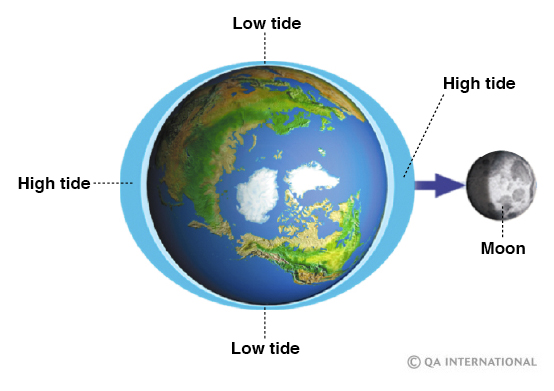

In [12]:
display(train_ds[101]["images"][0])

In [ ]:
train_ds[101]

In [ ]:
train_dataset[101]

In [15]:
train_dataset[101]["image"].shape

torch.Size([3, 224, 224])

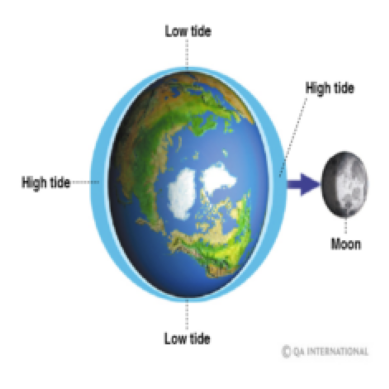

In [16]:
## 将处理后的图像输出
import matplotlib.pyplot as plt
img = train_dataset[101]["image"]  # e.g. data['image']
# 转成 H×W×C 并变成 numpy
np_img = img.permute(1, 2, 0).cpu().numpy()

plt.imshow(np_img)
plt.axis('off')
plt.show()

As you can see the model trains, so feel free to play around with the architecture or data! Let us know what you build with it!

PS: If you want to test the model, check out generate.py to see how to do inference with it

In [18]:
# 1. 返回的batch数据，一个batch包含12个样本
# 2. 对文本进行了padding处理，left padding
sample = next(iter(train_loader))
print(sample.keys())
print(sample) # 一个batch的数据，batch-size为：12

dict_keys(['image', 'input_ids', 'attention_mask', 'labels'])
{'image': tensor([[[[0.5373, 0.6039, 0.6039,  ..., 0.6039, 0.6039, 0.5333],
          [0.8667, 0.9922, 0.9961,  ..., 0.9961, 0.9961, 0.8784],
          [0.8706, 0.9882, 0.9961,  ..., 0.9961, 0.9961, 0.8784],
          ...,
          [0.8667, 0.9882, 0.9922,  ..., 0.9961, 0.9961, 0.8784],
          [0.8627, 0.9882, 0.9961,  ..., 0.9961, 0.9961, 0.8784],
          [0.5333, 0.6039, 0.6078,  ..., 0.6039, 0.6039, 0.5333]],

         [[0.5373, 0.6039, 0.6039,  ..., 0.6039, 0.6039, 0.5333],
          [0.8667, 0.9922, 0.9961,  ..., 0.9961, 0.9961, 0.8784],
          [0.8706, 0.9882, 0.9961,  ..., 0.9961, 0.9961, 0.8784],
          ...,
          [0.8667, 0.9882, 0.9922,  ..., 0.9961, 0.9961, 0.8784],
          [0.8627, 0.9882, 0.9961,  ..., 0.9961, 0.9961, 0.8784],
          [0.5333, 0.6039, 0.6078,  ..., 0.6039, 0.6039, 0.5333]],

         [[0.5373, 0.6039, 0.6039,  ..., 0.6039, 0.6039, 0.5333],
          [0.8667, 0.9922, 0.9961,  

In [20]:
sample["input_ids"][0]

tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 17872,    42, 15232,    42,
         1812,   314,   260,  1680,  1112,   282,   260, 18421,  1217,    47,
          198, 29943,   943,    42,   198,    49,    30, 19420,  1112,    30,
          198,    50,    30, 17812,  1112,    30,   198,    51,    30,   932,
         2296,    30,   198,    52,    30, 22981,    30,   198, 21350,   351,
          260,  4386,    30, 19842,    42, 21350,    42,   330,     0])

In [22]:
sample["labels"][0]

tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100, 21350,    42,   330,     0,  -100])

In [24]:
print(sample["input_ids"][0].shape)
print(sample["labels"][0].shape)

torch.Size([79])
torch.Size([79])


## **代码解读：模型处理部分：**
1. 模型架构是什么样的？
2. 一个数据，是如何被处理的？
3. Loss函数采用了什么？

In [12]:
train_loader, val_loader, test_loader = get_dataloaders(train_cfg, vlm_cfg)
tokenizer = get_tokenizer(vlm_cfg.lm_tokenizer)

# Initialize model （模型初始化部分）
if train_cfg.resume_from_vlm_checkpoint:
    # 模型继续训练，或者微调用
    model = VisionLanguageModel.from_pretrained(vlm_cfg.vlm_checkpoint_path)
else:
    # 模型初始化（通过VIT，projector，LLM来新建模型）
    model = VisionLanguageModel(vlm_cfg)

print(f"nanoVLM initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Training summary: {len(train_loader.dataset)} samples, {len(train_loader)} batches/epoch, batch size {train_cfg.batch_size}")

# Define optimizer groups
param_groups = [{'params': model.MP.parameters(), 'lr': train_cfg.lr_mp},
                {'params': list(model.decoder.parameters()) + list(model.vision_encoder.parameters()), 'lr': train_cfg.lr_backbones}]
optimizer = optim.AdamW(param_groups)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
if train_cfg.compile:
    model = torch.compile(model)

epoch_times = []
batch_losses = []
val_losses = []
val_plot_steps = []
best_accuracy = 0
global_step = 0


Loading from backbone weights


config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

Successfully loaded google/siglip-base-patch16-224 weights from safetensors. Model has 85,797,120 parameters.


config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

Successfully loaded HuggingFaceTB/SmolLM2-135M weights from safetensors. Model has 134,515,008 parameters.
nanoVLM initialized with 222,081,600 parameters
Training summary: 820 samples, 68 batches/epoch, batch size 12


In [26]:
model

VisionLanguageModel(
  (vision_encoder): ViT(
    (patch_embedding): ViTPatchEmbeddings(
      (conv): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x ViTBlock(
        (ln1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): ViTMultiHeadAttention(
          (qkv_proj): Linear(in_features=768, out_features=2304, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): ViTMLP(
          (activation_fn): GELU(approximate='tanh')
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
   

In [15]:
# 模型最基本的训练部分：单个batch处理
model.train()

batch=next(iter(train_loader)) # 获取单个batch的数据
images = batch["image"].to(device)
input_ids = batch["input_ids"].to(device)
labels = batch["labels"].to(device)
attention_mask = batch["attention_mask"].to(device)

optimizer.zero_grad() #重置梯度
with torch.autocast(device_type='cuda', dtype=torch.float16): # Mixed precision training
    _, loss = model(input_ids, images, attention_mask=attention_mask, targets=labels) # Forward

loss.backward() # backward
optimizer.step() # Update
batch_loss = loss.item()


VLM - imgage shape: torch.Size([12, 3, 224, 224])
VLM - after vision_encoder: torch.Size([12, 196, 768])
MP - Before pixel_shuffle: torch.Size([12, 196, 768])
MP - After pixel_shuffle: torch.Size([12, 49, 3072])
MP - After proj: torch.Size([12, 49, 576])
VLM - after MP: torch.Size([12, 49, 576])
VLM - after token_embedding (token_embd): torch.Size([12, 79, 576])
VLM - after token_embedding (combined_embd): torch.Size([12, 128, 576])
